In [790]:
import pandas as pd
import numpy as np
import yfinance as yf
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os


In [791]:
df = pd.read_csv("/Users/alvin/Documents/GitHub/AY2324S1-ML-Empowered-Stat-Arb/Data/individual_data/AAPL.csv")
print(df.shape)
print(df.columns)
print(df.index)

(2768, 10)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Log Returns', 'RSI', 'ATR'],
      dtype='object')
RangeIndex(start=0, stop=2768, step=1)


In [792]:
df.head()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [793]:
start_date = "2009-12-31"
end_date = "2019-12-31"
df = df[start_date:end_date]

In [794]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,Log Returns,RSI,ATR
Date,,,,,,,,,
2019-12-24,71.172501,71.222504,70.730003,71.067497,69.327438,48478800,0.000950,74.497767,0.957892
2019-12-26,71.205002,72.495003,71.175003,72.477501,70.702927,93121200,0.019646,78.722855,0.991436
2019-12-27,72.779999,73.492500,72.029999,72.449997,70.676086,146266000,-0.000380,78.449729,1.025083
2019-12-30,72.364998,73.172501,71.305000,72.879997,71.095566,144114400,0.005918,79.638715,1.085256
2019-12-31,72.482498,73.419998,72.379997,73.412498,71.615028,100805600,0.007280,81.034194,1.082024


In [795]:
split_idx = int(len(df)*0.8)
train = df.iloc[:split_idx]
test = df.iloc[split_idx:]
X_train = train.drop("Adj Close", axis=1)
y_train = train["Adj Close"]
X_test = test.drop("Adj Close", axis=1)
y_test = test["Adj Close"]

In [796]:
model = xgb.XGBRegressor(objective="reg:squarederror")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred

array([40.03523 , 40.576756, 40.83039 , 40.81059 , 41.301903, 41.338646,
       41.193756, 41.219078, 41.52771 , 41.607   , 41.447323, 41.54586 ,
       41.462578, 41.52838 , 41.429558, 41.47217 , 41.133553, 40.62895 ,
       40.736332, 40.127804, 39.261307, 38.87847 , 40.010666, 37.89175 ,
       36.786335, 38.650246, 37.621727, 36.746265, 36.731422, 38.59256 ,
       38.834515, 38.904736, 40.770695, 40.77334 , 40.673798, 40.494186,
       40.596783, 41.452415, 41.587788, 41.258713, 41.28497 , 41.346493,
       41.341637, 41.435486, 41.406017, 41.399788, 41.470997, 41.438057,
       41.49317 , 41.26849 , 41.403408, 41.408802, 41.395466, 41.19265 ,
       41.23316 , 40.493984, 39.991764, 40.039593, 40.560097, 39.83094 ,
       40.122013, 39.86626 , 39.968735, 39.929142, 40.686363, 40.738167,
       39.83875 , 40.31423 , 41.1187  , 40.682644, 41.142086, 41.336906,
       41.41948 , 41.459404, 41.399723, 40.731087, 39.961   , 38.86754 ,
       38.891224, 38.79488 , 38.788437, 38.86479 , 

In [797]:
# Augment the df using 2 lag variables
train2 = train.copy()
test2 = test.copy()
train2["Adj Close_lag1"] = train2["Adj Close"].shift(1)
train2["Adj Close_lag2"] = train2["Adj Close"].shift(2)
test2["Adj Close_lag1"] = test2["Adj Close"].shift(1)
test2["Adj Close_lag2"] = test2["Adj Close"].shift(2)
train2.head()

,Open,High,Low,Close,Adj Close,Volume,Log Returns,RSI,ATR,Adj Close_lag1,Adj Close_lag2
Date,,,,,,,,,,,
2009-12-31,7.611786,7.619643,7.520000,7.526071,6.388105,352410800,-0.004309,64.127988,0.149688,NaN,NaN
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.487533,493729600,0.015445,67.302467,0.148614,6.388105,NaN
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.498753,601904800,0.001728,67.650351,0.143968,6.487533,6.388105
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.395378,552160000,-0.016035,61.190419,0.145113,6.498753,6.487533
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.383556,477131200,-0.001850,60.479150,0.142273,6.395378,6.498753


In [798]:
train2.dropna(inplace=True)
test2.dropna(inplace=True)

In [799]:
X_train2 = train2.drop("Adj Close", axis=1)
y_train2 = train2["Adj Close"]
X_test2 = test2.drop("Adj Close", axis=1)
y_test2 = test2["Adj Close"]

In [800]:
# Sample dataset and training process
dtrain = xgb.DMatrix(X_train2, label=y_train2)
params = {
    'objective': 'reg:squarederror', 
    'eval_metric': 'rmse'
}
num_rounds = 100
bst = xgb.train(params, dtrain, num_rounds)
y_pred2 = bst.predict(xgb.DMatrix(X_test2))

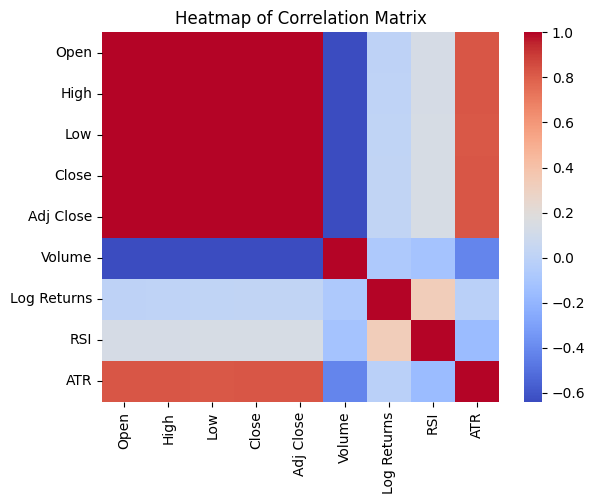

In [801]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, cmap="coolwarm")
plt.title("Heatmap of Correlation Matrix")
plt.show()

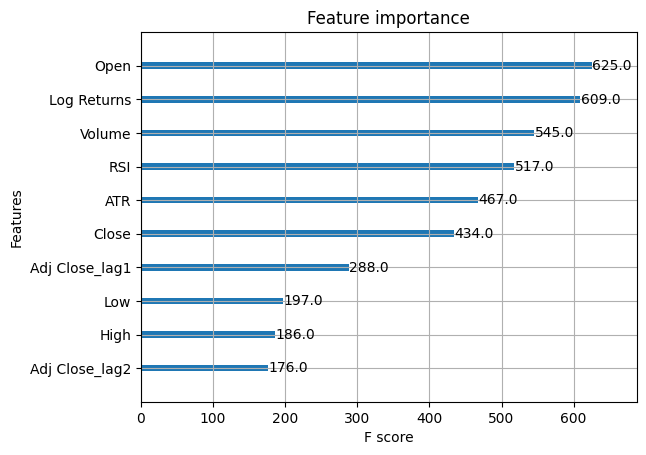

In [802]:
xgb.plot_importance(bst)
plt.show()

In [803]:
features = ["Adj Close", "ATR", "RSI", "Volume", "Adj Close_lag1", "Adj Close_lag2"]
def generate_data(df, r=0.9):
    df["Adj Close_lag1"]=df["Adj Close"].shift(1)    
    df["Adj Close_lag2"]=df["Adj Close"].shift(2)    
    df = df[features]
    df = df.dropna()
    idx = int(len(df)*r)
    train=df[:idx]
    test=df[idx:]
    X_train=train.drop("Adj Close", axis=1)
    y_train=train["Adj Close"]
    X_test=test.drop("Adj Close", axis=1)
    y_test=test["Adj Close"]
    return X_train, y_train, X_test, y_test

In [804]:
# function to clean the models directory
def delete_files_in_directory(directory_path):
    try:
        # Check if the directory exists
        if not os.path.exists(directory_path):
            print(f"The directory '{directory_path}' does not exist.")
            return

        # Get a list of all files in the directory
        files = os.listdir(directory_path)

        # Loop through the files and delete each one
        for file in files:
            file_path = os.path.join(directory_path, file)
            if os.path.isfile(file_path):
                os.remove(file_path)
                print(f"Deleted file: {file_path}")

        print("All files in the directory have been deleted.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

In [805]:
predictions = {}
true = {}
day_0_truth = {}
day_0 = None
assigned = False
indices = None
directory = '/Users/alvin/Documents/GitHub/AY2324S1-ML-Empowered-Stat-Arb/Data/individual_data'
model_directory = "/Users/alvin/Documents/GitHub/AY2324S1-ML-Empowered-Stat-Arb/alvin_research/models"

In [806]:
delete_files_in_directory(model_directory)
FIXED_STOCKS = False
stocks = ["FOX"]
if FIXED_STOCKS:
    for stock in stocks:        
        df = pd.read_csv(f"{directory}/{stock}.csv")
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)        
        X_train, y_train, X_test, y_test = generate_data(df)
        print(y_train)
        if day_0 == None:
            day_0 = y_train.index[-1]
        # Sample dataset and training process
        dtrain = xgb.DMatrix(X_train, label=y_train)
        params = {
            'objective': 'reg:squarederror', 
            'eval_metric': 'rmse'
        }
        num_rounds = 100
        bst = xgb.train(params, dtrain, num_rounds)
        predictions[stock] = bst.predict(xgb.DMatrix(X_test))
        true[stock] = y_test
        day_0_truth[stock]=y_train.iloc[-1]
        if not assigned:
            indices = y_test.index            
            assigned = True
        joblib.dump(bst, f"models/{stock}.joblib")
else:
    counter = 0
    for filename in os.listdir(directory):
        counter += 1
        if counter > 17:
            break
        if filename.endswith('.csv'):        
            df = pd.read_csv(directory + "/" + filename)
            df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        stock = filename.split(".")[0]
        X_train, y_train, X_test, y_test = generate_data(df)        
        if day_0 == None:
            day_0 = y_train.index[-1]
        # Sample dataset and training process
        dtrain = xgb.DMatrix(X_train, label=y_train)
        params = {
            'objective': 'reg:squarederror', 
            'eval_metric': 'rmse'
        }
        num_rounds = 100
        bst = xgb.train(params, dtrain, num_rounds)
        predictions[stock] = bst.predict(xgb.DMatrix(X_test))
        true[stock] = y_test
        print(stock)        
        day_0_truth[stock]=y_train.iloc[-1]
        if not assigned:
            indices = y_test.index
            assigned = True
        joblib.dump(bst, f"models/{stock}.joblib")

Deleted file: /Users/alvin/Documents/GitHub/AY2324S1-ML-Empowered-Stat-Arb/alvin_research/models/TROW.joblib
Deleted file: /Users/alvin/Documents/GitHub/AY2324S1-ML-Empowered-Stat-Arb/alvin_research/models/EQIX.joblib
Deleted file: /Users/alvin/Documents/GitHub/AY2324S1-ML-Empowered-Stat-Arb/alvin_research/models/MDT.joblib
Deleted file: /Users/alvin/Documents/GitHub/AY2324S1-ML-Empowered-Stat-Arb/alvin_research/models/DVN.joblib
Deleted file: /Users/alvin/Documents/GitHub/AY2324S1-ML-Empowered-Stat-Arb/alvin_research/models/TER.joblib
Deleted file: /Users/alvin/Documents/GitHub/AY2324S1-ML-Empowered-Stat-Arb/alvin_research/models/TPR.joblib
Deleted file: /Users/alvin/Documents/GitHub/AY2324S1-ML-Empowered-Stat-Arb/alvin_research/models/GILD.joblib
Deleted file: /Users/alvin/Documents/GitHub/AY2324S1-ML-Empowered-Stat-Arb/alvin_research/models/NVR.joblib
Deleted file: /Users/alvin/Documents/GitHub/AY2324S1-ML-Empowered-Stat-Arb/alvin_research/models/CSCO.joblib
Deleted file: /Users/alv

In [807]:
pred_df = pd.DataFrame({key: pd.Series(value) for key, value in predictions.items()})
true_df = pd.DataFrame({key: pd.Series(value) for key, value in true.items()})
day_0_truth_df = pd.DataFrame({key: pd.Series(value) for key, value in day_0_truth.items()})
pred_df.index=indices
true_df.index=indices
day_0_truth_df.index = pd.DatetimeIndex([day_0])
true_df_including_day_0 = pd.concat([day_0_truth_df, true_df], axis = 0)
true_df_including_day_0_excluding_last_day = true_df_including_day_0.drop(index = indices[-1])

In [808]:
true_df

,CSCO,UAL,TROW,ISRG,NVR,TPR,DVN,CE,MRO,BA,VRTX,GILD,EQIX,TER,MDT,V,QRVO
Date,,,,,,,,,,,,,,,,,
2018-11-23,38.272732,94.839996,79.262428,163.190002,2485.840088,32.720741,20.820757,92.428253,14.689288,303.480347,160.389999,54.451969,350.183289,34.952171,81.084183,128.688583,NaN
2018-11-26,39.157806,91.750000,80.359444,167.759995,2484.120117,33.641464,20.990971,93.507172,15.233681,307.405975,167.399994,54.738182,351.812714,35.692936,81.128250,131.662003,NaN
2018-11-27,39.630413,93.379997,79.446648,165.619995,2468.760010,32.434093,20.588638,90.108543,15.111664,309.028748,175.449997,55.147045,351.757324,35.438889,82.071198,131.632950,NaN
2018-11-28,40.635773,94.480003,82.352501,173.966660,2562.709961,33.441689,20.789808,90.351311,15.477718,324.060883,178.380005,56.578045,353.552521,35.565914,84.045212,136.930817,NaN
2018-11-29,40.678749,95.070000,81.958916,173.656662,2473.770020,33.016068,20.820757,90.405258,15.534038,332.864502,179.449997,56.986912,353.598541,34.559517,85.129143,134.722580,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,42.216801,89.150002,105.939957,199.603333,3817.149902,24.642441,20.879612,113.378014,12.969413,331.030457,220.559998,57.134697,538.226196,67.913170,102.452736,182.832947,117.959999
2019-12-26,42.278645,89.260002,106.520828,199.346664,3810.550049,25.094002,20.738003,113.120728,13.036069,327.968689,220.250000,56.852104,544.113159,68.543182,101.864616,184.382767,117.599998
2019-12-27,42.207970,88.370003,106.477478,199.293335,3816.370117,24.771458,20.242363,113.313690,12.836101,328.187408,220.970001,56.475311,546.920532,68.060822,102.561333,184.606918,116.839996


In [809]:
def generate_portfolio_weights(truth, pred):
    index = pred.index
    cols = pred.columns
    truth_values = truth.values
    pred_values = pred.values
    res = (pred_values - truth_values)/truth_values
    res_sums = np.sum(res, axis=1)[:, np.newaxis]
    scaled_res = res/res_sums
    weights = pd.DataFrame(data=scaled_res, columns=cols, index=index)
    return weights
    

In [810]:
portfolio_weights = generate_portfolio_weights(truth = true_df_including_day_0_excluding_last_day, pred = pred_df)

In [811]:
true_df.to_csv("truth.csv")
portfolio_weights.to_csv("portfolio_weights.csv")

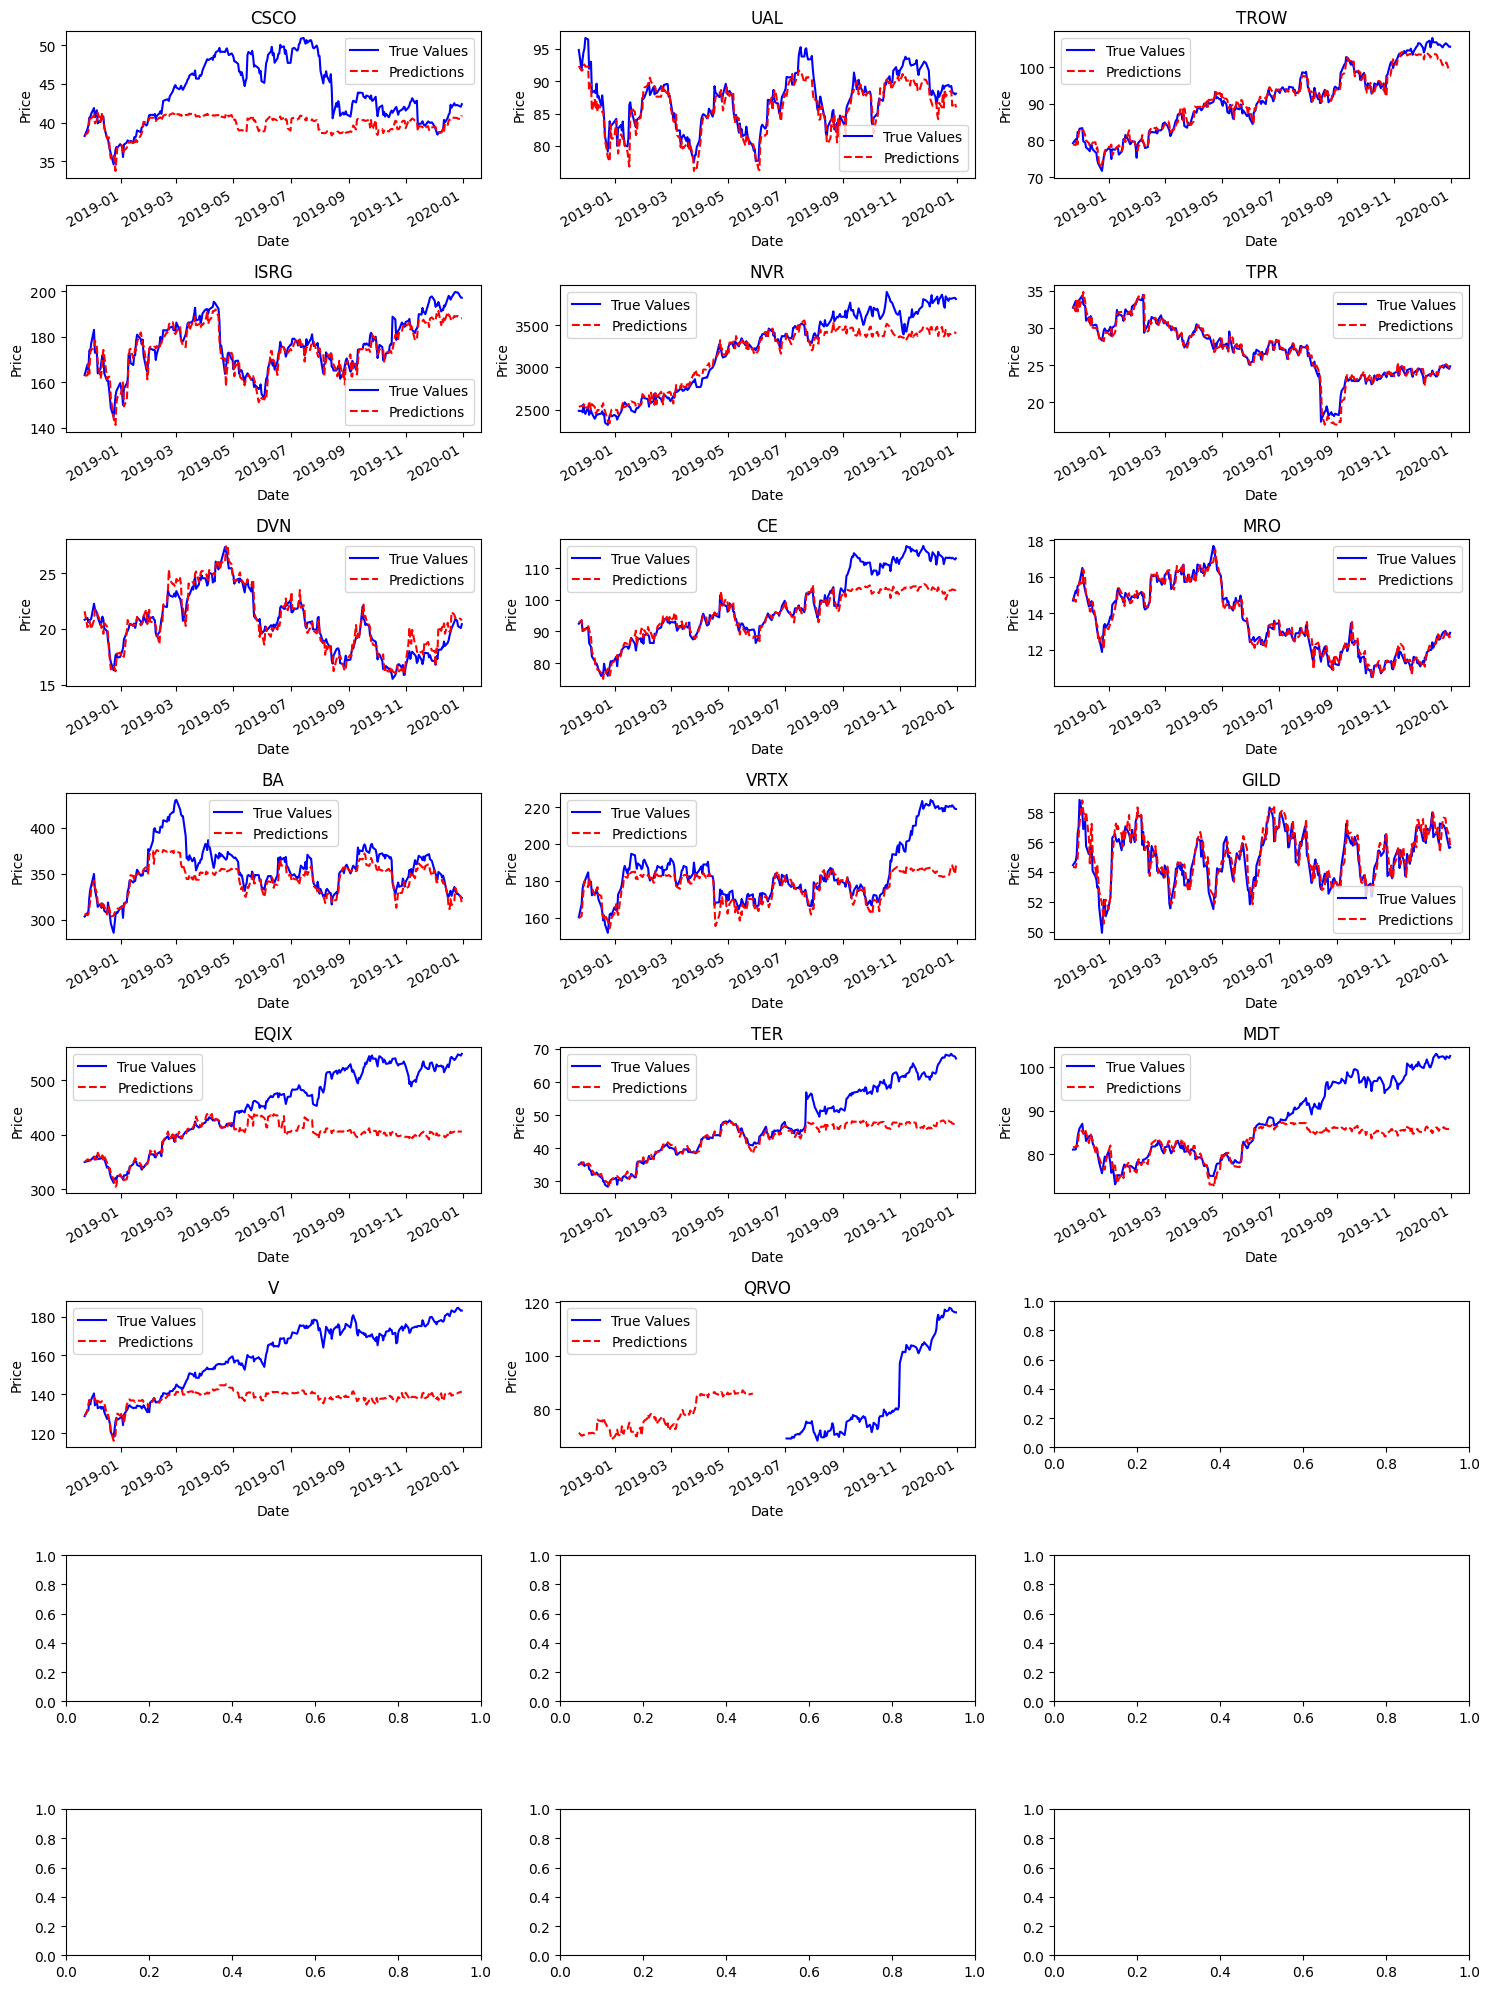

In [812]:
fig, axes = plt.subplots(8, 3, figsize=(15, 4 * 5))
for idx, stock in enumerate(pred_df.columns):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    true_df[stock].plot(ax=ax, label="True Values", color="blue")
    pred_df[stock].plot(ax=ax, label="Predictions", linestyle="--", color="red")
    
    ax.set_title(stock)
    ax.set_ylabel("Price")
    ax.legend()

plt.tight_layout()
plt.show()